DESCRIPTION

Identify the level of income qualification needed for the families in Latin America

Problem Statement Scenario:
Many social programs have a hard time making sure the right people are given enough aid. It’s tricky when a program focuses on the poorest segment of the population. This segment of population can’t provide the necessary income and expense records to prove that they qualify.

In Latin America, a popular method called Proxy Means Test (PMT) uses an algorithm to verify income qualification. With PMT, agencies use a model that considers a family’s observable household attributes like the material of their walls and ceiling or the assets found in their homes to classify them and predict their level of need. While this is an improvement, accuracy remains a problem as the region’s population grows and poverty declines.

The Inter-American Development Bank (IDB) believes that new methods beyond traditional econometrics, based on a dataset of Costa Rican household characteristics, might help improve PMT’s performance.

Following actions should be performed:
* Identify the output variable.
* Understand the type of data.
* Check if there are any biases in your dataset.
* Check whether all members of the house have the same poverty level.
* Check if there is a house without a family head.
* Set the poverty level of the members and the head of the house same in a family.
* Count how many null values are existing in columns.
* Remove null value rows of the target variable.
* Predict the accuracy using random forest classifier.
* Check the accuracy using a random forest with cross-validation.

In [67]:
from pandas import read_csv, DataFrame
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.simplefilter(action='ignore')

In [44]:
inq = read_csv("train.csv")
inqtst = read_csv('test.csv')
inq

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0000,100.0000,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0000,144.0000,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0000,121.0000,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0000,121.0000,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0000,121.0000,1369,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9552,ID_d45ae367d,80000.0,0,6,0,1,1,0,NaN,0,...,81,2116,25,81,1,1.562500,0.0625,68.0625,2116,2
9553,ID_c94744e07,80000.0,0,6,0,1,1,0,NaN,0,...,0,4,25,81,1,1.562500,0.0625,68.0625,4,2
9554,ID_85fc658f8,80000.0,0,6,0,1,1,0,NaN,0,...,25,2500,25,81,1,1.562500,0.0625,68.0625,2500,2
9555,ID_ced540c61,80000.0,0,6,0,1,1,0,NaN,0,...,121,676,25,81,1,1.562500,0.0625,68.0625,676,2


In [45]:
# * Identify the output variable.
# print(inqtst.columns, '\n', len(inqtst.columns))
print(inq.shape, inqtst.shape)
np.setdiff1d(inq.columns,inqtst.columns)

(9557, 143) (23856, 142)


array(['Target'], dtype=object)

In [46]:
# * Understand the type of data.
dtypelist = list(DataFrame(inq.dtypes).groupby(by=0))
[(ll[0],len(ll[1])) for ll in dtypelist]

[(dtype('int64'), 130), (dtype('float64'), 8), (dtype('O'), 5)]

In [47]:
dtypelist[2][1]

,0
Id,object
idhogar,object
dependency,object
edjefe,object
edjefa,object


## using idhogar (Household level identifier) as the family identifier, checking Target column is having same value.
## All members of the house does not have the same poverty level in many families

In [48]:
# hogar_total corresponding to idhogar should be same. Conservation check
hogar_chk = np.concatenate([inq.hogar_total[inq.idhogar==xx].unique() for xx in inq.idhogar.value_counts().index])
hogar_chk

array([13, 12, 12, ...,  1,  1,  1], dtype=int64)

In [49]:
unidhog = inq.idhogar.value_counts()
unidhog

fd8a6d014    13
ae6cf0558    12
0c7436de6    12
b7a0b59d7    11
4476ccd4c    11
             ..
9f6b2b309     1
75226a178     1
1637ac45b     1
0194d569d     1
21eb7fcc1     1
Name: idhogar, Length: 2988, dtype: int64

## These are the households in which the members have different poverty levels.
    Target column corresponding to idhogar should be same.
     If different collect those idhogar
     replace the differeing values by max poverety level

In [50]:
def pov_leveler(ids):
    unq = inq.Target[inq.idhogar==ids].unique()
    if len(unq) > 1:
        return (ids, max(unq))
    else:
        return None
def pov_rm(pair):
    inq['Target'][inq.idhogar == pair[0]] = pair[1]
    
pov_diffs = list(filter(lambda xx: xx is not None, [pov_leveler(abc) for abc in unidhog.index]))                 


In [51]:
xtra = [pov_rm(cl)  for cl in pov_diffs]


In [52]:
pov_diff1 = list(filter(lambda xx: xx is not None, [pov_leveler(abc) for abc in unidhog.index]))
pov_diff1

[]

In [53]:
inq[['edjefa','edjefe']] = inq[['edjefa','edjefe']].replace(to_replace=['yes','no'], value=[1,0]).astype(int)
inq['dependency'] = inq['dependency'].replace(to_replace=['yes','no'], value=[1,0]).astype(float)
inqtst[['edjefa','edjefe']] = inqtst[['edjefa','edjefe']].replace(to_replace=['yes','no'], value=[1,0]).astype(int)
inqtst['dependency'] = inqtst['dependency'].replace(to_replace=['yes','no'], value=[1,0]).astype(float)
# inqtst['edjefe'].value_counts()

In [54]:
inq.loc[:,['edjefa','edjefe','dependency']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   edjefa      9557 non-null   int32  
 1   edjefe      9557 non-null   int32  
 2   dependency  9557 non-null   float64
dtypes: float64(1), int32(2)
memory usage: 149.5 KB


In [55]:
# null value treatment
nul_cols = inq.isnull().sum()[inq.isnull().sum() > 0]
nul_cols

v2a1         6860
v18q1        7342
rez_esc      7928
meaneduc        5
SQBmeaned       5
dtype: int64

In [56]:
inqtst.isnull().sum()[inq.isnull().sum() > 0]

v2a1         17403
v18q1        18126
rez_esc      19653
meaneduc        31
SQBmeaned       31
dtype: int64

In [57]:
nul_cols.index

Index(['v2a1', 'v18q1', 'rez_esc', 'meaneduc', 'SQBmeaned'], dtype='object')

In [58]:
inq['meaneduc'].fillna(value=0,inplace=True)
inqtst['meaneduc'].fillna(value=0,inplace=True)
inq.drop(columns=['v2a1', 'v18q1', 'rez_esc'], inplace=True)
inqtst.drop(columns=['v2a1', 'v18q1', 'rez_esc'], inplace=True)

In [59]:
# * Check if there are any biases in your dataset.
# These are squares of some of the features in the data set and hence are multicolinear of first kind 
sqs = inq.filter(regex="^SQB|sq$").columns.to_list() + ['Id','idhogar']
inq.drop(columns=sqs,inplace=True)
inqtst.drop(columns=sqs,inplace=True)

In [60]:
y = inq['Target']
inq.drop(columns=['Target'],inplace=True)
rfc = RandomForestClassifier(random_state=66)
rfc.fit(inq,y)
ypred = rfc.predict(inqtst)

In [66]:
print(accuracy_score(y,ypred[:9557]),accuracy_score(y,ypred[9557:2*9557]))

0.578738097729413 0.5573924871821702


In [69]:
# cross validation
cross_val_score(rfc, inq, y, cv=5)

array([0.66004184, 0.64435146, 0.65149137, 0.50130822, 0.54997384])

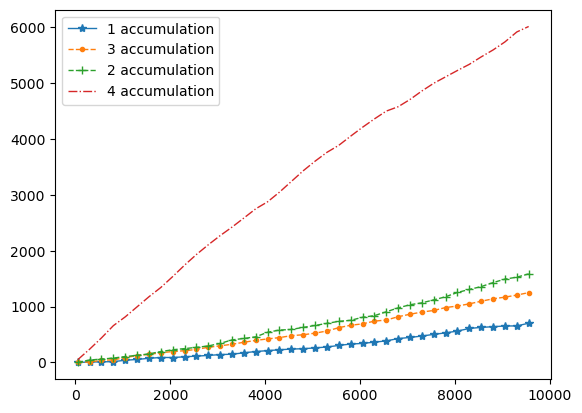

In [18]:
# interesting linearity of the data
# this provides a outer bound, may be if put into might increase the accuracy
base = np.arange(50,9557,250)
def points(xv,gra):
    ob = inq['Target'][0:xv]
    cu = np.arange(0,xv)
    return len(cu[ob==gra])
lst1234 = [list(map(lambda v:points(v,g),base)) for g in (1,2,3,4)]

plt.plot(base,lst1234[0],'-*',linewidth=1, label='1 accumulation')
plt.plot(base,lst1234[2],'--.',linewidth=1, label='3 accumulation')
plt.plot(base,lst1234[1],'--+',linewidth=1, label='2 accumulation')
plt.plot(base,lst1234[3],'-.',linewidth=1, label='4 accumulation')
plt.legend()
plt.show()